## Importing libraris and dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [4]:
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Times New Roman'

&nbsp;

## Control Charts And Simulation

### 2.1. Control Charts in Phase I

In Phase I, control charts are used on retrospective data to calculate preliminary control limits and determine if the process had been in control during the period where the data was collected. Below is an example of control charts in phase 1. (more specifically, Control "C" Chart)

The data below pertains to the entry of individuals into an institution:

__Day One:__ 6, 7, 7, 23, 10, 3, 6, 11, 12, 9, 7, 10, 8, 29, 14, 12, 8, 16, 8, 30, 5, 9

__Day Two:__
10, 14, 8, 7, 5, 10, 9, 8, 5, 8, 9, 14, 13, 18, 9, 6, 16, 13, 12, 12, 11, 24

Each working day consists of 11 hours from 7 am to 6 pm. (On the first day, from 7 am to 7:30 am, 6 people entered the institution, and from 7:30 am to 8 am, 7 people entered and so on...)

In [5]:
day1_data = np.array([6,7,7,23,10,3,6,11,12,9,7,10,
                      8,29,14,12,8,16,8,30,5,9])
day2_data = np.array([10,14,8,7,5,10,9,8,5,8,9,14,13,
                      18,9,6,16,13,12,12,11,24])

In [6]:
num_of_people = np.concatenate((day1_data, day2_data))
mean_value_c = np.mean(num_of_people)

In [7]:
l = 3
ucl_c = mean_value_c + l*np.sqrt(mean_value_c)
lcl_c = max(mean_value_c - l*np.sqrt(mean_value_c),0)

In [8]:
ucls = [ucl_c]
lcls = [lcl_c]
means = [mean_value_c]
data_list = [num_of_people]

In [9]:
out_of_control_idx = np.where((num_of_people>ucl_c) | (num_of_people<lcl_c))[0]
while len(out_of_control_idx) > 0:
    num_of_people = np.delete(num_of_people, out_of_control_idx)
    data_list.append(num_of_people)
    
    mean_value_c = np.mean(num_of_people)
    means.append(mean_value_c)
    
    ucl_c = mean_value_c + l*np.sqrt(mean_value_c)
    ucls.append(ucl_c)
    
    lcl_c = max(mean_value_c - l*np.sqrt(mean_value_c),0)
    lcls.append(lcl_c)
    
    out_of_control_idx = np.where((num_of_people>ucl_c) | (num_of_people<lcl_c))[0]

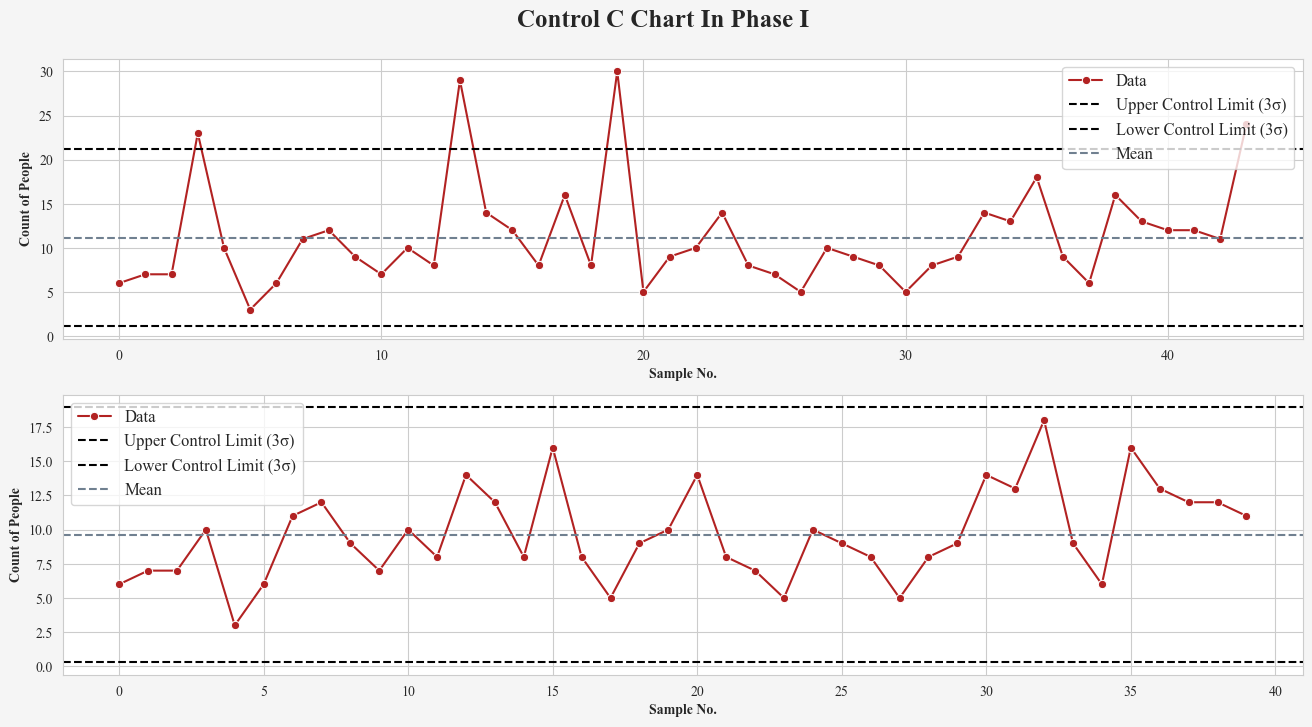

In [10]:
fig, ax = plt.subplots(len(means), 1, figsize=(16,8), facecolor='whitesmoke')

plt.text(x=0.5, y=0.92, s="Control C Chart In Phase I", fontsize=18,
         fontweight='bold', ha="center", transform=fig.transFigure)

for i in range(len(means)):
    sns.lineplot(data_list[i], marker='o', color='firebrick', ax=ax[i], label='Data')
    ax[i].axhline(ucls[i], color='black', linestyle='--', label='Upper Control Limit (3σ)')
    ax[i].axhline(lcls[i], color='black', linestyle='--', label='Lower Control Limit (3σ)')
    ax[i].axhline(means[i], color='slategray', linestyle='--', label='Mean')
    ax[i].legend(prop={'size':12})
    ax[i].set_xlabel('Sample No.', fontweight='bold')
    ax[i].set_ylabel('Count of People', fontweight='bold');

&nbsp;

### 2.2. ARL Calculation for EWMA Control Charts in Phase II

| Shift in Mean<br>(multiple of σ) | L=3.054<br>λ=0.40 | 2.998<br>0.25 | 2.962<br>0.20 | 2.814<br>0.10 | 2.615<br>0.05 |
| --- | --- | --- | --- | --- | --- |
| 0 | 500 | 500 | 500 | 500 | 500 |
| 0.25 | 224 | 170 | 150 | 106 | 84.1 |
| 0.50 | 71.2 | 48.2 | 41.8 | 31.3 | 28.8 |
| 0.75 | 71.2 | 48.2 | 41.8 | 31.3 | 28.8 |
| 1.00 | 14.3 | 11.1 | 10.5 | 10.3 | 11.4 |
| 1.50 | 5.9 | 5.5 | 5.5 | 6.1 | 7.1 |
| 2.00 | 3.5 | 3.6 | 3.7 | 4.4 | 5.2 |
| 2.50 | 2.5 | 2.7 | 2.9 | 3.4 | 4.2 |
| 3.00 | 2.0 | 2.3 | 2.4 | 2.9 | 3.5 |
| 4.00 | 1.4 | 1.7 | 1.9 | 2.2 | 2.7 |

First, we define _'calculate_arl_ewma'_ function to calculate the Average Run Length (ARL). Then, we generate the table above (which is taken from chapter 9 of Introduction to Statistical Quality Control by Montgomery) using that function.

In [11]:
def calculate_arl_ewma(l, lamda, shift_size, mu0, sigma0):
    alpha=.0027; iter_num=10000; sigma_xbar=sigma0*np.sqrt(lamda/(2-lamda))
    ucl = mu0 + l * sigma_xbar
    lcl = mu0 - l * sigma_xbar
    rls = [] #Rls
    for i in range(iter_num):
        rl = 0; est_zi = mu0
        while lcl < est_zi < ucl:
            x = np.random.normal(mu0+(shift_size*sigma0), sigma0, 1)
            est_zi = lamda*x + (1-lamda)*est_zi
            rl += 1
        rls.append(rl)
    return np.round(np.mean(rls), decimals=1)

In [12]:
l_values = [3.054, 2.998, 2.962, 2.814, 2.615]
lambda_values = [.4, .25, .2, .1, .05] 
shift_sizes = [0, .25, .5, .75, 1, 1.5, 2, 2.5, 3, 4]

arls = np.zeros((len(shift_sizes), len(l_values))) #Empty array for calculating ARLs using the defined function
for i, shift in enumerate(shift_sizes):
    for j,(l,lamda) in enumerate(zip(l_values, lambda_values)):
        arls[i,j] = calculate_arl_ewma(l, lamda, shift, 1.5, 0.15)

arls = np.hstack(([[f'shift={x}'] for x in shift_sizes],arls))
print(tabulate(arls, headers=[f'L={x}\nLambda={y}' for x,y in zip(l_values,lambda_values)]))

                 L=3.054        L=2.998       L=2.962       L=2.814        L=2.615
              Lambda=0.4    Lambda=0.25    Lambda=0.2    Lambda=0.1    Lambda=0.05
----------  ------------  -------------  ------------  ------------  -------------
shift=0            496.9          496.7         502.3         497.1          496.2
shift=0.25         226.5          171.5         150.2         105             83.8
shift=0.5           71.1           47.8          42.3          31.5           28.5
shift=0.75          27.8           20            18.1          15.8           16.4
shift=1             14.3           11.2          10.5          10.3           11.4
shift=1.5            5.9            5.5           5.5           6.1            7.1
shift=2              3.5            3.6           3.7           4.4            5.2
shift=2.5            2.5            2.7           2.9           3.4            4.2
shift=3              2              2.3           2.4           2.9            3.5
shif